# COURSE: A deep understanding of deep learning
## SECTION: Autoencoders
### LECTURE: AEs for occlusion
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [2]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [3]:
# # import dataset (comes with colab!)
# data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# # don't need labels!
# data = data[:,1:]

# # normalize the data to a range of [0 1]
# dataNorm = data / np.max(data)

# # convert to tensor
# dataT = torch.tensor( dataNorm ).float()

import torchvision.datasets as datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True)

train_data = mnist_train.data
train_labels = mnist_train.targets
test_data = mnist_test.data
test_labels = mnist_test.targets

# reshape data to 2D tensor
train_data = train_data.reshape(-1, 28*28).float()
test_data = test_data.reshape(-1, 28*28).float()

labels = torch.cat((train_labels, test_labels), dim=0)
data = torch.cat((train_data, test_data), dim=0)

# extract labels (number IDs) and remove from data
# labels = data[:,0]
# data   = data[:,1:]

dataNorm = data / np.max(data.numpy())

labelsPy = labels.numpy()
dataPy = data.numpy()

print(dataNorm.shape)
print(labels.shape)

dataT = torch.tensor(dataNorm)

torch.Size([70000, 784])
torch.Size([70000])


/tmp/ipykernel_554604/4270108361.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataT = torch.tensor(dataNorm)


# Demonstration of implementing occlusion

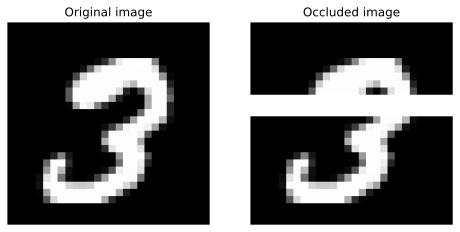

In [4]:
# reconstruct a sample as an image

img = dataT[12345,:].view(28,28)


occluded = copy.deepcopy( img )
occluded[10:13,:] = 1

fig,ax = plt.subplots(1,2,figsize=(8,5))

ax[0].imshow(img,cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(occluded,cmap='gray')
ax[1].set_title('Occluded image')
ax[1].axis('off')

plt.show()

# Create the DL model

In [5]:
# create a class for the model
def createTheMNISTAE():

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,128)

      ### encoder layer
      self.enc = nn.Linear(128,50)

      ### latent layer
      self.lat = nn.Linear(50,128)

      ### decoder layer
      self.dec = nn.Linear(128,784)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.enc(x) )
      x = F.relu( self.lat(x) )
      y = torch.sigmoid( self.dec(x) )
      return y

  # create the model instance
  net = aenet()

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

# Create a function that trains the model

In [6]:
def function2trainTheModel():

  # number of epochs
  numepochs = 5

  # create a new model
  net,lossfun,optimizer = createTheMNISTAE()

  # initialize losses
  losses = []



  # batch size and number of batches
  batchsize  = 32
  numBatches = int(dataT.shape[0]/batchsize)


  # loop over epochs (now each epoch goes through all samples)
  for epochi in range(numepochs):


    # get a permuted index vector
    randidx = np.random.permutation(dataT.shape[0]).astype(int)

    for batchi in range(numBatches):

      # samples to use in this batch
      samps2use = range((batchi-1)*batchsize,batchi*batchsize)


      # select those images
      X = dataT[randidx[samps2use],:]

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      # losses in this batch
      losses.append( loss.item() )

  # end epochs

  # function output
  return losses,net

# Run the model and show the results!

Final loss: 0.0070


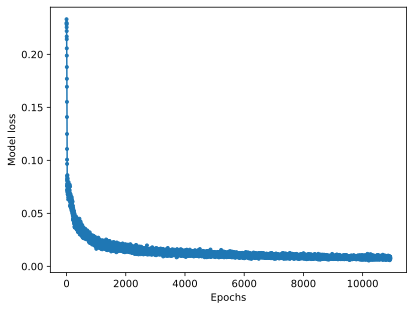

In [7]:
# train the model (16s)
losses,net = function2trainTheModel()
print(f'Final loss: {losses[-1]:.4f}')

# visualize the losses
plt.plot(losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.show()

# Add occlusion to some images

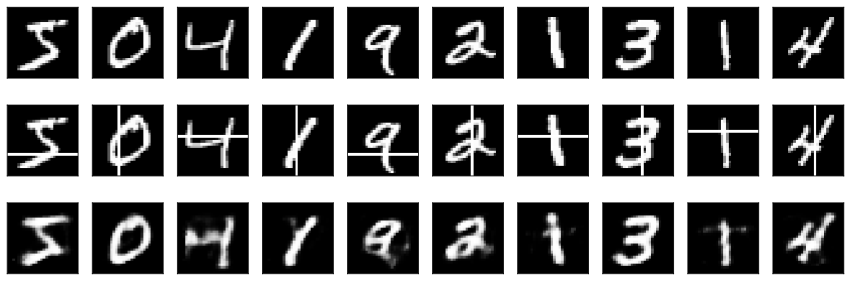

In [8]:
# grab a small set of images
X = copy.deepcopy( dataT[:10,:] )

# add noise
for i in range(X.shape[0]):

  # reshape the image
  img = X[i,:].view(28,28)

  # occlude random rows or columns
  startloc = np.random.choice(range(10,21))
  if i%2==0: # even -> horizontal occlusion
    img[startloc:startloc+1,:] = 1
  else:      # odd -> vertical occlusion
    img[:,startloc:startloc+1] = 1



# run the samples through the model
deOccluded = net(X)


# show the noisy images
fig,axs = plt.subplots(3,10,figsize=(15,5))

for i in range(10):
  axs[0,i].imshow(dataT[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[2,i].imshow(deOccluded[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  axs[2,i].set_xticks([]), axs[2,i].set_yticks([])

plt.show()

# Something more quantitative

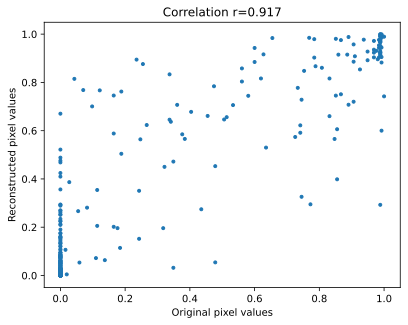

In [9]:
# We can quantify the performance of our "de-occluder" by correlating the sample with the original.

inOutCorr = np.corrcoef(dataT[9,:].detach(),deOccluded[9,:].detach())

# and plot
plt.plot(dataT[9,:].detach(),deOccluded[9,:].detach(),'.')
plt.xlabel('Original pixel values')
plt.ylabel('Reconstructed pixel values')
plt.title(f'Correlation r={ inOutCorr[0,1] :.3f}')
plt.show()

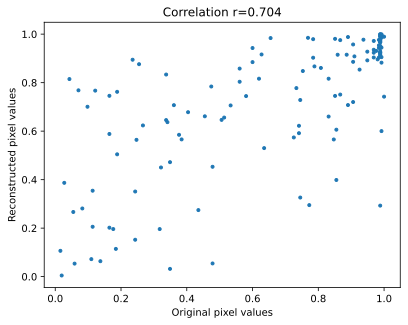

In [10]:
# try again without the zero-valued pixels
# We do this, because we have a lot of black pixels (0)
# This is not fair to the model, because it can easily predict 0 for all pixels and get a high correlation.

# extract to variables for convenience
orig  = dataT[9,:].detach()
recon = deOccluded[9,:].detach()

# boolean vector that indicates pixels>0 (with some tolerance)
tol = 1e-4
nonzeropixels = (orig>tol) & (recon>tol)

# then re-compute the correlation
inOutCorr = np.corrcoef(orig[nonzeropixels],recon[nonzeropixels])

# redraw the previous plot
plt.plot(orig[nonzeropixels],recon[nonzeropixels],'.')
plt.xlabel('Original pixel values')
plt.ylabel('Reconstructed pixel values')
plt.title(f'Correlation r={ inOutCorr[0,1] :.3f}')
plt.show()

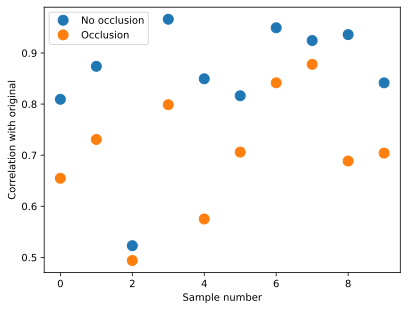

In [11]:
# get data with no occlusion
noOcclusion = net(dataT[:10,:])

# compare deOccluded-original to noOcclusion-original correlation
r = np.zeros((10,2))
for i in range(deOccluded.shape[0]):

  # pixel selection (note: tolerance defined in previous cell)
  nonzeropixels = (dataT[i,:]>tol) & (noOcclusion[i,:]>tol) & (deOccluded[i,:]>tol)

  # now compute the correlations
  r[i,0] = np.corrcoef(dataT[i,nonzeropixels].detach(),noOcclusion[i,nonzeropixels].detach())[0,1]
  r[i,1] = np.corrcoef(dataT[i,nonzeropixels].detach(),deOccluded[i,nonzeropixels].detach())[0,1]


# plot the correlation coefficients
plt.plot(r,'o',markersize=10)
plt.legend(['No occlusion','Occlusion'])
plt.xlabel('Sample number')
plt.ylabel('Correlation with original')
plt.show()

# Create occlusion for all images

In [12]:
# grab a small set of images
fullOccludedImages = copy.deepcopy( dataT )

print(fullOccludedImages.shape)
print(fullOccludedImages.shape[0])
print(fullOccludedImages.shape[1])
print(dataT[9,:].shape)

# add noise
for i in range(fullOccludedImages.shape[0]):
    # reshape the image
    img = fullOccludedImages[i,:].view(28,28)

    # occlude random rows or columns
    startloc = np.random.choice(range(10,21))
    if i%2==0: # even -> horizontal occlusion
        img[startloc:startloc+1,:] = 1
    else:      # odd -> vertical occlusion
        img[:,startloc:startloc+1] = 1

torch.Size([70000, 784])
70000
784
torch.Size([784])


# Pass all ocluded images through the model

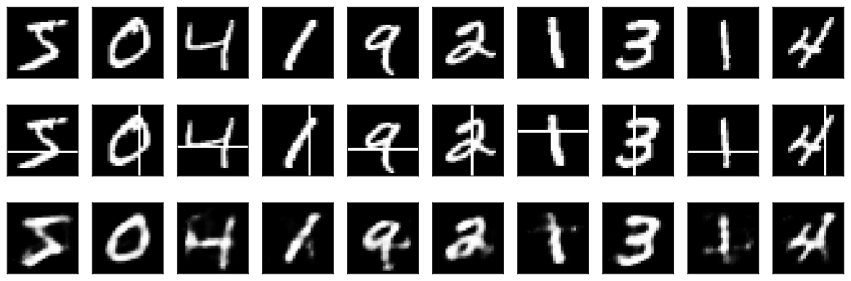

In [13]:
# run the samples through the model
fullDeOccludedImages = net(fullOccludedImages)


# show the noisy images
fig,axs = plt.subplots(3,10,figsize=(15,5))

for i in range(10):
  axs[0,i].imshow(dataT[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(fullOccludedImages[i,:].view(28,28).detach() ,cmap='gray')
  axs[2,i].imshow(fullDeOccludedImages[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  axs[2,i].set_xticks([]), axs[2,i].set_yticks([])

plt.show()

# Correlation for each sample

In [14]:
rFull = np.zeros((fullOccludedImages.shape[0],2))

for i in range(fullOccludedImages.shape[0]):
    tol = 1e-4
    nonzeropixels = (dataT[i,:]>tol) & (fullOccludedImages[i,:]>tol) & (fullDeOccludedImages[i,:]>tol)

    # now compute the correlations
    rFull[i,0] = np.corrcoef(dataT[i,nonzeropixels].detach(),fullOccludedImages[i,nonzeropixels].detach())[0,1]
    rFull[i,1] = np.corrcoef(dataT[i,nonzeropixels].detach(),fullDeOccludedImages[i,nonzeropixels].detach())[0,1]

/home/jbermejo/repo/DeepUnderstandingOfDeepLearning/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/jbermejo/repo/DeepUnderstandingOfDeepLearning/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


# Average correlation for each number

In [15]:
averageR = np.zeros(10)

rFull = np.nan_to_num(rFull)

for i in range(10):
    averageR[i] = np.mean(rFull[labels==i,:])

print(averageR)

[0.84938926 0.81811969 0.81277516 0.83087929 0.80629055 0.80742522
 0.80586412 0.82106271 0.80087751 0.81227381]


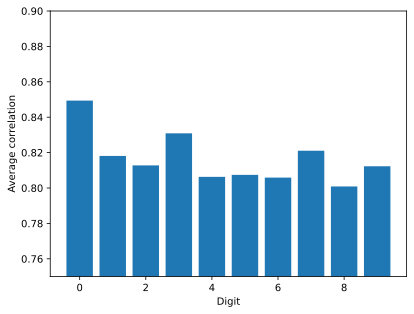

In [16]:
plt.bar(range(10),averageR)
plt.xlabel('Digit')
plt.ylabel('Average correlation')
plt.ylim([0.75,0.9])
plt.show()

# Binarise data and calculate accuracy

In [17]:
dataBinarised = copy.deepcopy(dataT)
dataBinarised[dataBinarised > 0] = 1

fullDeOccludedBinarised = fullDeOccludedImages.clone()
fullDeOccludedBinarised[fullDeOccludedBinarised>0] = 1

# now compute the correlations
rFull[i,0] = np.corrcoef(dataT[i,nonzeropixels].detach(),fullOccludedImages[i,nonzeropixels].detach())[0,1]
rFull[i,1] = np.corrcoef(dataT[i,nonzeropixels].detach(),fullDeOccludedImages[i,nonzeropixels].detach())[0,1]

# Compute the number of overlapping pixels
overlap_pixels = (dataBinarised * fullDeOccludedBinarised).sum(dim=1)
total_pixels = dataBinarised.sum(dim=1)

print(overlap_pixels)
print(total_pixels)

# Calculate the overlap ratio
overlap_ratio = overlap_pixels / total_pixels

print(overlap_ratio)
print(overlap_ratio.mean())

# I don't think this is working

tensor([166., 176., 120.,  ..., 164., 149., 240.], grad_fn=<SumBackward1>)
tensor([166., 176., 120.,  ..., 164., 149., 240.])
tensor([1., 1., 1.,  ..., 1., 1., 1.], grad_fn=<DivBackward0>)
tensor(1., grad_fn=<MeanBackward0>)


# MSE for each number

MSE: 0.8086
[0.75539454 0.89043453 0.78463512 0.79151562 0.81898204 0.80528558
 0.79881219 0.83239939 0.77851592 0.81716575]


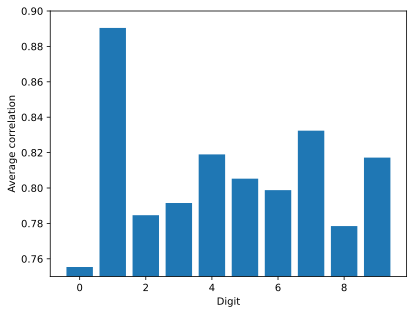

In [20]:
# Calculate MSE
mse = torch.mean((dataBinarised - fullDeOccludedBinarised) ** 2)
print(f'MSE: {mse.item():.4f}')

# MSE for each number
mseFull = np.zeros(fullDeOccludedBinarised.shape[0])

for i in range(fullDeOccludedBinarised.shape[0]):
    mseFull[i] = torch.mean((dataBinarised[i] - fullDeOccludedBinarised[i]) ** 2).item()

averageMSE = np.zeros(10)

# averageMSE = np.nan_to_num(mseFull)

for i in range(10):
    averageMSE[i] = np.mean(mseFull[labels==i])

print(averageMSE)

plt.bar(range(10),averageMSE)
plt.xlabel('Digit')
plt.ylabel('Average correlation')
plt.ylim([0.75,0.9])
plt.show()

# Additional explorations

In [ ]:
# 1) Does occlusion affect some numbers more than others? Run the entire dataset through the autoencoder with occluded
#    images. Compute the image correlations for each sample. Then compute the average correlation for each number (image
#    label). Show the results in a plot. (Bonus: Also compute the standard deviation across correlations and use those
#    to draw error bars.) What do the results tell you about the difficulty of fixing occlusions in images?
#
#    Some numbers are harder than others (obviously). Simple shapes like 0 are easy to fix, while more complex shapes
#    like 4,5 or 8 are harder to fix. The average correlation is higher for simple shapes and lower for complex shapes.
#
# 2) Perhaps a correlation coefficient isn't really the best performance metric. Try this: Binarize the images like we
#    did in the video "CodeChallenge: Binarized MNIST images" (section FFN). Then compute the number of pixels in the
#    original and reconstructed images that overlap (hint: try summing them). Make sure your new metric has a possible
#    range of 0 (absolutely no overlap) to 1 (perfect overlap). Does this metric seem more consistent with your visual
#    intuition?
#
#    I don't think so. And I don't think I've achieved it to make it work. In any case, I don't like this. It will
#    probably be a good metric, but I don't have time to do it now
#
# 3) But wait a minute, don't we already have a quantitative measure of the similarity between the AE input and output?
#    Of course we do -- it's the loss function! Mean-squared error already accounts for zeros because those get ignored
#    [zero-valued pixels have MSE=(0-0)**2 ]. In fact, question #2 is kindof a "rough MSE." Take a moment to write down
#    the formulas for MSE and correlation, and see whether they are related (hint: the relationship isn't linear because of
#    the squared term). Finally, compute MSE on our example occlusion images and compare MSE to correlation empirically
#    by making a scatter plot. (Hint 1: Use more than 10 examples to see trends. Hint 2: Consider the signs (+/-).)
#
#    I like this metric (so I guess I was doing it wrong previously). Here the results make more sense, as values like
#    the 1 have higher mse values (and a 1 is way simpler than a 0 per example). 
#
# Note about exercises 2&3: MSE really is the best loss function for this problem. The purpose of these exercises is to
#    get you thinking critically about autoencoders, loss functions, and the idea of using custom-designed quantitative
#    comparisons measures. I hope you find these problems enjoyable and thought-provoking!
#